# Case Study: Sentiment Analysis

### Setup

Import modules, read data

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import nltk

sns.set()

# Read in the data
df = pd.read_csv("https://raw.githubusercontent.com/feb-sofia/ta2023/main/data/reviews.csv")
# Sample the data to speed up computation
# Comment out this line to match with lecture

df.head()


,Unnamed: 0,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,394349,Sony XPERIA Z2 D6503 FACTORY UNLOCKED Internat...,NaN,244.95,5,Very good one! Better than Samsung S and iphon...,0.0
1,34377,Apple iPhone 5c 8GB (Pink) - Verizon Wireless,Apple,194.99,1,"The phone needed a SIM card, would have been n...",1.0
2,248521,Motorola Droid RAZR MAXX XT912 M Verizon Smart...,Motorola,174.99,5,I was 3 months away from my upgrade and my Str...,3.0
3,167661,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,1,an experience i want to forget,0.0
4,73287,Apple iPhone 7 Unlocked Phone 256 GB - US Vers...,Apple,922.00,5,GREAT PHONE WORK ACCORDING MY EXPECTATIONS.,1.0


In [17]:
# Remove missing values
df.dropna(inplace=True)

# Drop reviews with neutral ratings
df = df[df['Rating'] != 3]

"Super! No problem with the phone"
"Many problems with the phone"

# Map ratings 4 and 5 to "positive" 
# Map ratings 1 and 2 to "negative"
df["positive"] = np.where(df['Rating'] > 3, 1, 0)
df.Reviews.head(50)

1     The phone needed a SIM card, would have been n...
2     I was 3 months away from my upgrade and my Str...
3                        an experience i want to forget
4           GREAT PHONE WORK ACCORDING MY EXPECTATIONS.
5     I fell in love with this phone because it did ...
6     I am pleased with this Blackberry phone! The p...
7     Great product, best value for money smartphone...
9             I've bought 3 no problems. Fast delivery.
10                         Great phone for the price...
11    My mom is not good with new technoloy but this...
12    The charger didnt work, I suppose that it mean...
13    I loved it and thanks so much because you made...
14    Amazing phone especially for the price. I love...
16    I purchase it for my friend, she like it alot ...
17    I generally dont write reviews but this phone ...
18    I bought this phone for my mom and sent it to ...
19                                         got me going
20    Happy to be back! I broke my Lumia 1520.3 

In [18]:
# Most ratings are positive
df['positive'].mean()

0.7475259604695931

In [19]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'],
                                                    df['positive'],
                                                    random_state=0)

In [20]:
print('X_train first entry:\n\n', X_train.iloc[0])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry:

 Broke in like 20 mins


X_train shape:  (27662,)


# CountVectorizer

In [21]:
# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(X_train)

In [22]:
vect.get_feature_names_out()[::2000]
vect.get_feature_names_out()[::2000]

array(['00', 'antennae', 'changer', 'dijeron', 'flickering',
       'incremental', 'metter', 'phoblem', 'resold', 'states', 'untimely'],
      dtype=object)

Number of features generated

In [23]:
len(vect.get_feature_names_out())

21374

In [24]:
len(y_train)

27662

In [25]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<27662x21374 sparse matrix of type '<class 'numpy.int64'>'
	with 736995 stored elements in Compressed Sparse Row format>

In [26]:
# Train the model
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_vectorized, y_train)

LogisticRegression(max_iter=2000)

Compute the ROC curve and plot it. Compute the area under the ROC curve.

AUC:  0.8959253676234809


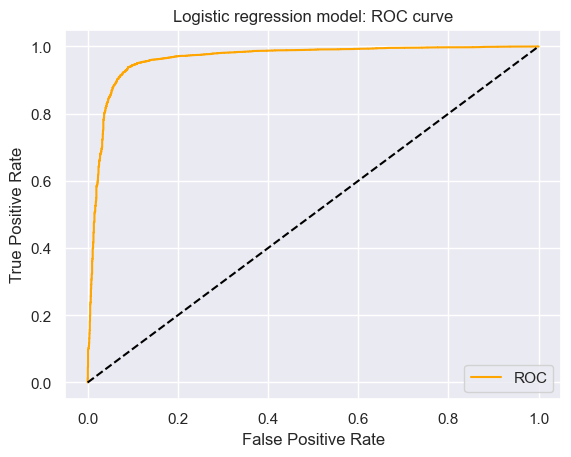

In [28]:
# Predict the transformed test documents
predictions = logreg.predict(vect.transform(X_test))
logreg_probs = logreg.predict_proba(vect.transform(X_test))
logreg_positive_probs = [p[1] for p in logreg_probs]

fpr, tpr, thresholds = roc_curve(y_test, logreg_positive_probs)

## Predicted probabilities from the logistic regression model
print('AUC: ', roc_auc_score(y_test, predictions))

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Logistic regression model: ROC curve')
    plt.legend()
    plt.show()


plot_roc(fpr, tpr)

In [29]:
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names_out())

# Sort the coefficients from the model
sorted_coef_index = logreg.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['worst' 'terrible' 'waste' 'sucks' 'junk' 'poor' 'useless' 'broken'
 'slow' 'garbage']

Largest Coefs: 
['excelent' 'excelente' 'excellent' 'love' 'perfectly' 'perfect' 'loves'
 'amazing' 'exactly' 'great']


# TF-IDF

Fit another logistic regression model. This time vectorize using the DF-IDF vectorization.

In [31]:
# Fit the TfidfVectorizer to the training data specifying a minimum document frequency of 5
idf_vect = TfidfVectorizer()
idf_vect.fit(X_train)
len(idf_vect.get_feature_names_out())

21374

In [34]:
X_train_vectorized_idf = idf_vect.transform(X_train)

model = LogisticRegression(max_iter=2000)
model.fit(X_train_vectorized_idf, y_train)

predictions_idf = model.predict(idf_vect.transform(X_test))

print('AUC: Count', roc_auc_score(y_test, predictions))
print('AUC TF-IDF: ', roc_auc_score(y_test, predictions_idf))

AUC: Count 0.8959253676234809
AUC TF-IDF:  0.8948881392277619


In [35]:
feature_names = np.array(vect.get_feature_names_out())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['jumped' 'outta' 'outstand' 'outsources' 'outsource' 'outsmarts'
 'outshines' 'outter' 'outshine' 'outs']

Largest tfidf: 
['the' 'and' 'this' 'phone' 'to' 'it' 'is' 'you' 'iphone' 'of']


In [36]:
sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['not' 'slow' 'doesn' 'worst' 'disappointed' 'terrible' 'return' 'never'
 'waste' 'poor']

Largest Coefs: 
['great' 'love' 'excellent' 'best' 'good' 'perfect' 'price' 'awesome'
 'far' 'amazing']


In [38]:
# These reviews are treated the same by our current model
print(model.predict(idf_vect.transform(['not an issue',
                                        'an issue'])))

[0 1]


# N-grams

Fit a third logistic regression model using the TF-IDF vectorization. This time include
bi-grams as features and exclude features with document frequency less than 5.

In [39]:
# Fit the CountVectorizer to the training data specifiying a minimum 
# document frequency of 5 and extracting unigrams and bigrams

vect = CountVectorizer(min_df=5, ngram_range=(1, 2)).fit(X_train)

X_train_vectorized = vect.transform(X_train)

len(vect.get_feature_names_out())

33883

In [40]:
model = LogisticRegression(max_iter=5000)
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.9150383329628612


In [41]:
feature_names = np.array(vect.get_feature_names_out())

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['no good' 'junk' 'worst' 'broken' 'sucks' 'poor' 'terrible' 'horrible'
 'not good' 'not']

Largest Coefs: 
['excellent' 'excelente' 'excelent' 'perfect' 'great' 'not bad'
 'no problems' 'love' 'awesome' 'amazing']


In [42]:
# These reviews are now correctly identified
print(
    model.predict(
        vect.transform(['not an issue',
                        'an issue']))
)

[1 1]
